In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from skimage import io, filters, measure

import warnings
warnings.filterwarnings('ignore')


In [2]:
# define input path
inputpath = '/Users/giselemiranda/ToOneDrive/BIIF/projects/Feria_Cecilia' # example '/Users/projects/'

# read reference image
ref_img = io.imread(os.path.join(inputpath, '20460260_Scan1_Core[1,2,A]_[12663,40371]_component_data.tif - resolution #3.tif'))
nuclei = ref_img[0,:,:]

In [3]:
from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# get predictions for nuclei 
labels, _ = model.predict_instances(normalize(nuclei))

# get binary mask
binary_mask = labels.copy()
binary_mask[binary_mask > 0] = 1

io.imsave(inputpath + 'labels.tif',labels)
io.imsave(inputpath + 'binary.tif',binary_mask)


2023-05-02 13:37:40.684765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
1/1 [==============================] - 1s 846ms/step


Text(0.5, 1.0, 'prediction + input overlay')

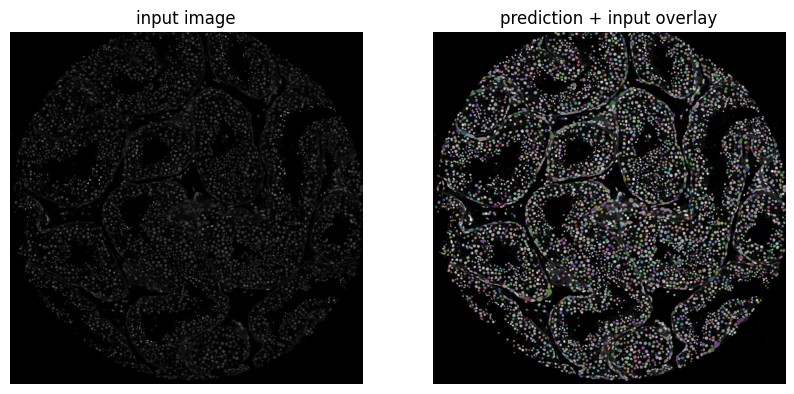

In [4]:
# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(nuclei, cmap="gray", vmin=0, vmax=np.amax(nuclei))
ax1.axis("off")
ax1.set_title('input image')

ax2.imshow(render_label(labels, img=nuclei))
ax2.axis("off")
ax2.set_title('prediction + input overlay')


In [85]:
images = [ref_img[(x),:,:] for x in range(ref_img.shape[0])]

properties = ['label', 'intensity_mean']

tables = [measure.regionprops_table(labels, image, properties=properties)
          for image in images]
tables = [pd.DataFrame(table) for table in tables] # create dataframe for each table
tables = [table.set_index('label') for table in tables] # reset segmentaiton label as table index

mean_intens = pd.concat(tables, axis=1)
mean_intens.columns = ['DAPI','OPAL480','OPAL520','OPAL570','OPAL620','OPAL690','OPAL780','Autofluorescence']
mean_intens


8


,DAPI,OPAL480,OPAL520,OPAL570,OPAL620,OPAL690,OPAL780,Autofluorescence
label,,,,,,,,
1,26.035524,14.300614,4.995111,0.350100,1.136611,5.724508,0.156195,7.793913
2,21.532436,8.359867,12.215379,0.196066,2.934078,0.515699,0.268638,8.096065
3,19.351835,6.115076,7.944694,0.423977,2.742765,1.259455,3.121698,7.400581
4,24.532646,8.237246,5.902200,0.393453,1.481363,6.433295,0.288688,7.997678
5,28.376553,15.220303,7.021153,0.328195,1.617007,5.684114,0.119549,8.465516
...,...,...,...,...,...,...,...,...
4871,8.135657,3.105014,6.383780,0.187832,0.667581,0.115370,0.076790,7.351696
4872,30.657665,2.373475,3.327082,0.213146,0.420516,0.139443,0.075289,7.391753
4873,15.697083,2.994924,6.047880,0.455162,16.691502,3.263204,0.413688,7.335554


### Defining threshold for each column

In [66]:
from skimage.filters import threshold_otsu

hist, bin_edges = np.histogram(mean_intens['DAPI'], 1000, density=True)

thresh = threshold_otsu(mean_intens['OPAL520'])
thresh


10.474706615554169

In [ ]:
fig, axis = plt.subplots(2,4,figsize=(8, 3))
mean_intens.hist(ax=axis)


(0.0, 1200.0)

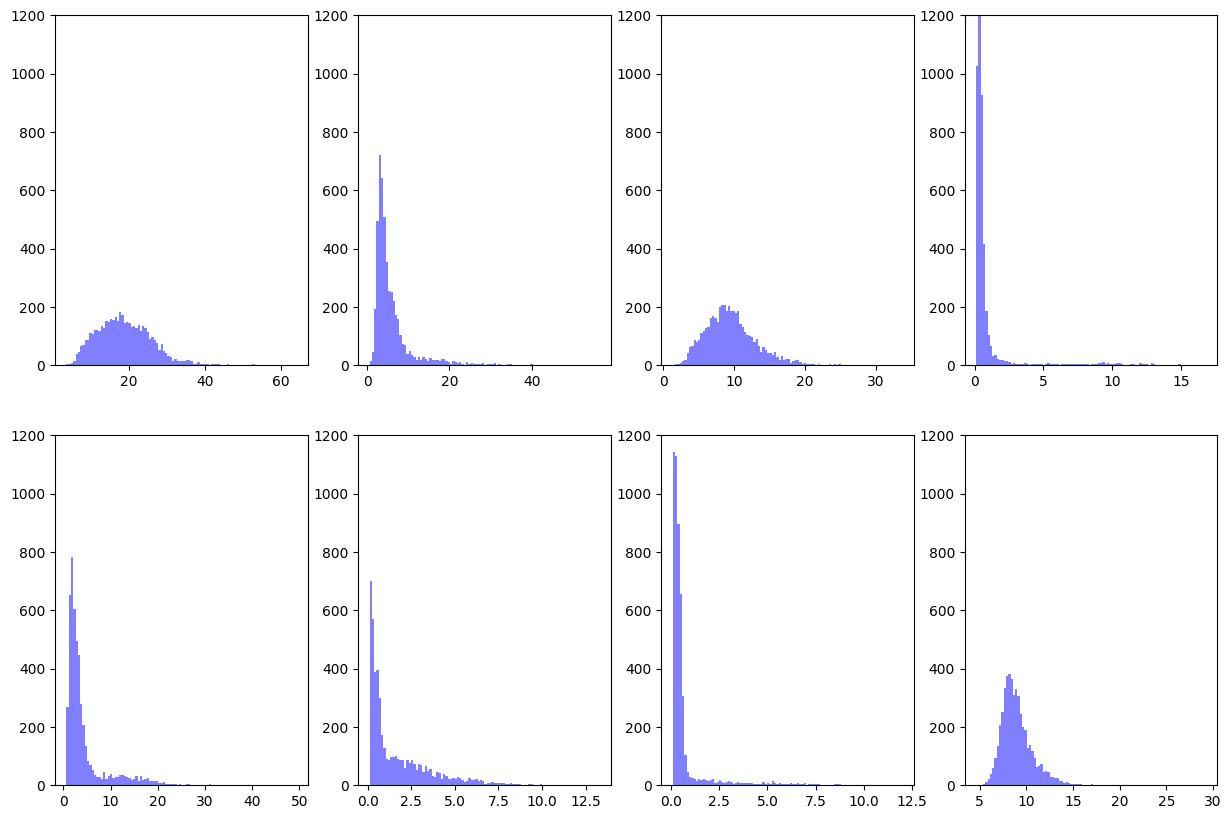

In [97]:
# create subplot
fig, axarr = plt.subplots(2,4, figsize=(15, 10)) 
nBins = 100
# plot distance histogram

counts, bins = np.histogram(mean_intens['DAPI'],bins=nBins,density=False)
binWidth = bins[1] - bins[0]
axarr[0,0].bar(bins[1:], counts, width=binWidth, facecolor='b', alpha=0.5)
#axarr[0,0].set_xlim([0,80])
axarr[0,0].set_ylim([0,1200])

counts, bins = np.histogram(mean_intens['OPAL480'],bins=nBins,density=False)
binWidth = bins[1] - bins[0]
axarr[0,1].bar(bins[1:], counts, width=binWidth, facecolor='b', alpha=0.5)
#axarr[0,1].set_xlim([0,80])
axarr[0,1].set_ylim([0,1200])

counts, bins = np.histogram(mean_intens['OPAL520'],bins=nBins,density=False)
binWidth = bins[1] - bins[0]
axarr[0,2].bar(bins[1:], counts, width=binWidth, facecolor='b', alpha=0.5)
#axarr[0,2].set_xlim([0,80])
axarr[0,2].set_ylim([0,1200])

counts, bins = np.histogram(mean_intens['OPAL570'],bins=nBins,density=False)
binWidth = bins[1] - bins[0]
axarr[0,3].bar(bins[1:], counts, width=binWidth, facecolor='b', alpha=0.5)
#axarr[0,3].set_xlim([0,80])
axarr[0,3].set_ylim([0,1200])

counts, bins = np.histogram(mean_intens['OPAL620'],bins=nBins,density=False)
binWidth = bins[1] - bins[0]
axarr[1,0].bar(bins[1:], counts, width=binWidth, facecolor='b', alpha=0.5)
#axarr[1,0].set_xlim([0,80])
axarr[1,0].set_ylim([0,1200])

counts, bins = np.histogram(mean_intens['OPAL690'],bins=nBins,density=False)
binWidth = bins[1] - bins[0]
axarr[1,1].bar(bins[1:], counts, width=binWidth, facecolor='b', alpha=0.5)
#axarr[1,1].set_xlim([0,80])
axarr[1,1].set_ylim([0,1200])

counts, bins = np.histogram(mean_intens['OPAL780'],bins=nBins,density=False)
binWidth = bins[1] - bins[0]
axarr[1,2].bar(bins[1:], counts, width=binWidth, facecolor='b', alpha=0.5)
#axarr[1,2].set_xlim([0,80])
axarr[1,2].set_ylim([0,1200])

counts, bins = np.histogram(mean_intens['Autofluorescence'],bins=nBins,density=False)
binWidth = bins[1] - bins[0]
axarr[1,3].bar(bins[1:], counts, width=binWidth, facecolor='b', alpha=0.5)
#axarr[1,3].set_xlim([0,80])
axarr[1,3].set_ylim([0,1200])
